In [1]:
#Install tqdm to have progress bar
!pip install tqdm
!pip3 install mtcnn
#install necessary pkg to make connection with elasticsearch domain
# !pip install elasticsearch
# !pip install requests
# !pip install requests-aws4auth

     |████████████████████████████████| 2.3 MB 4.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import json
import time
import tensorflow as tf
import PIL.Image as Image
import numpy as np
import datetime
import zipfile
# import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from PIL import Image
from mtcnn.mtcnn import MTCNN

In [4]:
mydir = ("./lfw")
check_folder = os.path.isdir(mydir)
lfw_dir = './drive/MyDrive/lfw_lite_mtcnn.zip'
if not check_folder: 
  with zipfile.ZipFile(lfw_dir, 'r') as zip_ref:
    zip_ref.extractall('./lfw/')

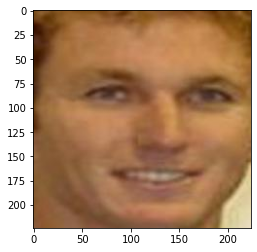

In [5]:
import cv2
import matplotlib.pyplot as plt
f = '/content/lfw/test/Aaron_Peirsol/Aaron_Peirsol_00020.jpg'
img = cv2.imread(f)
img = cv2.resize(img, (224, 224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [6]:
# Set the channel first for better performance
from tensorflow.keras import backend
backend.set_image_data_format('channels_last')
print(backend.image_data_format())

channels_last


In [7]:
#Import Resnet50 model
img_height = img_width = 224
img_shape = (img_height, img_width)
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3), pooling='avg')
model.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [8]:
num_classes = 2000 # pulled from the loading data code block

def addClassLayer(model, num_classes=num_classes):
  # Prevent transfer learning from modifying variables
  # Transfer learning will only modify the new classifier layer(s)
  # One layer for classification (741 classes as of lfw_subset), one layer for downsampling feature vector (1024 of 2048)

  output = model.get_layer('avg_pool').output
  # output = Flatten(name = 'Flatten_last')(output)
  output = Dense(1024, activation='relu', name='feature_vec')(output)
  output = Dense(num_classes, activation='softmax')(output)
  resnet50_model = Model(model.input, output)

  return resnet50_model

In [9]:
# model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3), pooling='avg')
# model.trainable = False
model = addClassLayer(model, num_classes)
# model.summary()

In [10]:
## Transfer Learning
# https://medium.com/analytics-vidhya/cnn-transfer-learning-with-vgg-16-and-resnet-50-feature-extraction-for-image-retrieval-with-keras-53320c580853
# https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
# Hyper-parameter testing: filter size, dropout effect, number of convolutional layers

In [11]:
detector = MTCNN()
def extract_face_from_image(image):
  # image = plt.imread(image_path)
  required_size = (224, 224)
  faces = detector.detect_faces(image)

  confidence = 0
  face_array = None
  for face in faces:
    conf = face['confidence']
    if conf < confidence:
      continue
    # extract the bounding box from the requested face
    x1, y1, width, height = face['box']
    x2, y2 = x1 + width, y1 + height

    # extract the face
    face_boundary = image[y1:y2, x1:x2]

    # resize pixels to the model size
    face_image = Image.fromarray(face_boundary)
    face_image = face_image.resize(required_size)
    face_array = np.asarray(face_image)
    # face_array = face_array/255.
    
    confidence = conf

  return face_array

In [12]:
# file_root = "./drive/MyDrive/lfw_subset2"
# file_root_train = f"{file_root}/examples_gteq4"

# file_root = "./drive/MyDrive/lfw_subset_mtcnn"
# file_root_train = "./drive/MyDrive/lfw_subset_mtcnn"

file_root = file_root_train = "./lfw"

# batch_size = 32
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     file_root_train,
#     validation_split=0.5,
#     subset="training",
#     seed=12345,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     file_root_train,
#     validation_split=0.5,
#     subset="validation",
#     seed=12345,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )



batch_size = 32

def generators(shape=(224,224), preprocessing=extract_face_from_image): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        # preprocessing_function = preprocessing
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        '/content/lfw/train/',
        target_size = (height, width), 
        batch_size = batch_size
    )

    val_dataset = imgdatagen.flow_from_directory(
        '/content/lfw/test/',
        target_size = (height, width), 
        batch_size = batch_size
    )
    return train_dataset, val_dataset

In [13]:
train_ds, val_ds = generators((224,224), preprocessing=extract_face_from_image)

Found 15000 images belonging to 2000 classes.
Found 5000 images belonging to 2000 classes.


In [14]:
# Comment out this block if I implement additional preprocessing in generators function
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [15]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

In [17]:
# ## Training the ResNet50 model
num_epochs = 10

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss = 'categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs
)

Epoch 1/10
469/469 [==============================] - 51s 86ms/step - loss: 7.0522 - acc: 0.0305 - val_loss: 4.9847 - val_acc: 0.2176
Epoch 2/10
469/469 [==============================] - 39s 82ms/step - loss: 3.1289 - acc: 0.4691 - val_loss: 2.4924 - val_acc: 0.5798
Epoch 3/10
469/469 [==============================] - 38s 82ms/step - loss: 1.5239 - acc: 0.7173 - val_loss: 1.7644 - val_acc: 0.7104
Epoch 4/10
469/469 [==============================] - 38s 82ms/step - loss: 0.9112 - acc: 0.8275 - val_loss: 1.4261 - val_acc: 0.7792
Epoch 5/10
469/469 [==============================] - 38s 82ms/step - loss: 0.5796 - acc: 0.8869 - val_loss: 1.2010 - val_acc: 0.8218
Epoch 6/10
469/469 [==============================] - 38s 82ms/step - loss: 0.3807 - acc: 0.9251 - val_loss: 1.0588 - val_acc: 0.8544
Epoch 7/10
469/469 [==============================] - 38s 82ms/step - loss: 0.2582 - acc: 0.9465 - val_loss: 1.0268 - val_acc: 0.8624
Epoch 8/10
469/469 [==============================] - 38s 82ms

In [18]:
def create_embeddings(data_path,train=True,output_path='./drive/MyDrive/resnet50_lfw/'):
  folders = os.listdir(data_path)
  labels = []
  paths = []
  images = []

  for person in folders:
    files = os.listdir(data_path+person)
    for img in files:
      # try:
      image = cv2.imread(data_path+person+'/'+img)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      images.append(image)
      # except Exception as e:
      #   print(e)
      #   continue
      labels.append(person)
      paths.append(data_path+person+'/'+img)
  
  embeddings = []
  pre_labels = labels
  labels = []

  pre_images = images
  images = []

  pre_paths = paths
  paths = []

  for index, img in enumerate(pre_images):
    img_cropped = extract_face_from_image(img)
    if img_cropped is not None:
      img_embedding = model.predict(img_cropped.reshape(1, img_height, img_width, 3))
      labels.append(pre_labels[index])
      images.append(pre_images[index])
      paths.append(pre_paths[index])
      embeddings.append(img_embedding)

  df = pd.DataFrame({'embeddings':embeddings,'label':labels})
  label_counts = df['label'].value_counts()
  print(f"Num Labels: {label_counts}")

  embeddings = np.array(embeddings)
  labels = np.array(labels)
  paths = np.array(paths)
  labels_w_paths = np.stack([labels, paths], axis = 1)

  if train:
    np.save(output_path+'embeddings_train.npy', embeddings)
    np.save(output_path+'labels_train.npy', labels_w_paths)
  else:
    np.save(output_path+'embeddings_test.npy', embeddings)
    np.save(output_path+'labels_test.npy', labels_w_paths)
        
  return embeddings, labels_w_paths

In [19]:
mydir = ("./data")
check_folder = os.path.isdir(mydir)
lfw_dir = './drive/MyDrive/lfw_lite.zip'
if not check_folder: 
  with zipfile.ZipFile(lfw_dir, 'r') as zip_ref:
    zip_ref.extractall('./data/')

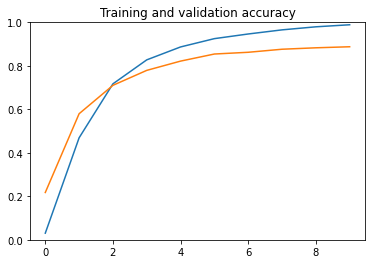

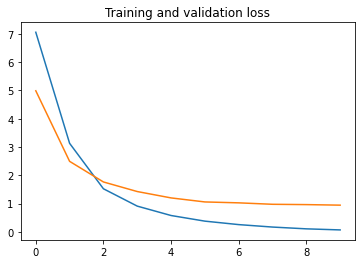

In [20]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()


plot_history(history, yrange=(0,1))

In [21]:
# %load_ext tensorboard
# %tensorboard --logdir "./drive/MyDrive/RevImgSearch_logs/"

In [22]:
# predicted_batch = model.predict(image_batch)
# predicted_id = tf.math.argmax(predicted_batch, axis=-1)
# predicted_label_batch = class_names[predicted_id]
# print(predicted_label_batch)

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# plt.figure(figsize=(10,9))
# plt.subplots_adjust(hspace=0.5)

# for n in range(30):
#   plt.subplot(6,5,n+1)
#   plt.imshow(image_batch[n])
#   plt.title(predicted_label_batch[n].title())
#   plt.axis('off')
# _ = plt.suptitle("Model predictions")

In [25]:
import cv2
import pandas as pd
import glob
import matplotlib.image as mpimg

In [26]:
def getFeatureVector(model, img_path, img_height=img_height, img_width=img_width):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (img_height, img_width))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # img = img/255.
  feature_vector = model.predict(img.reshape(1, img_height, img_width, 3))
  return feature_vector

In [27]:
def getCosineSimilarity(A, B):
  cos_similarity = np.dot(A,B.T) / (np.linalg.norm(A)*np.linalg.norm(B)) # Get cosine similarity
  return cos_similarity[0][0]

In [28]:
def getEuclideanDistance(A, B):
  dist = np.linalg.norm(A - B)
  return dist

In [29]:
def getFeatureDataFrame(model):
  df = pd.DataFrame(columns=['file', 'features'])
  files = glob.glob(file_root + '/*/*/*.jpg', recursive=True)
  # files = glob.glob(file_root + '/*/*/*.jpg', recursive=True)
  print(len(files))
  df['file'] = files
  df['features'] = df.apply(lambda row: getFeatureVector(model, row['file']), axis=1) 

  print("All files added.")
  return df

In [30]:
def getSimilarImages(img_file, features_df, model, cos=True, plot=True):
  img_features = getFeatureVector(model, img_file)
  if cos:
    features_df['similarity'] = features_df.apply(lambda row: getCosineSimilarity(img_features, np.asarray(row['features'])), axis=1)  
    sorted_df = features_df.sort_values(by='similarity', ascending=False)  
  else:
    features_df['similarity'] = features_df.apply(lambda row: getEuclideanDistance(img_features, np.asarray(row['features'])), axis=1)
    sorted_df = features_df.sort_values(by='similarity', ascending=True)

  if plot:
    plt.figure(figsize=(50,5))

    for n in range(9):
      fname = sorted_df.iloc[n]['file']
      plt.subplot(int(f"19{n+1}"))
      plt.imshow(mpimg.imread(fname))
      plt.axis('off')
    _ = plt.suptitle("Model predictions")
  plt.show()
  return sorted_df

In [31]:
feature_model_resnet50 = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)
df = getFeatureDataFrame(feature_model_resnet50)

20000
All files added.


In [32]:
def getFeatureDataFrame2(model, base_path='./lfw/train', train=True):
  df = pd.DataFrame(columns=['label', 'file', 'features'])
  files_local = glob.glob(base_path + '/*/*.jpg', recursive=True)
  files = [f.replace('./lfw', './data/lfw_lite') for f in files_local]
  # ./data/lfw_lite/test/person/person.jpg
  person = [s.strip().split('/')[4] for s in files]
  # files = glob.glob(file_root + '/*/*/*.jpg', recursive=True)
  print(len(files))
  print(len(person))
  print(files[:3])
  print(person[:3])
  df['label'] = person
  df['file'] = files
  # df['features'] = df.apply(lambda row: getFeatureVector(model, row['file']), axis=1) 
  df['features'] = [getFeatureVector(model, fl) for fl in files_local]

  labels = df[['label','file']].to_numpy()
  embeddings = df['features'].to_numpy()

  output_path='./drive/MyDrive/resnet50_lfw/'
  if train:
    np.save(output_path+'embeddings_train_resnet50.npy', embeddings)
    np.save(output_path+'labels_train_resnet50.npy', labels)
  else:
    np.save(output_path+'embeddings_test_resnet50.npy', embeddings)
    np.save(output_path+'labels_test_resnet50.npy', labels)

  print("All files added.")
  return df

In [33]:
df_train = getFeatureDataFrame2(feature_model_resnet50)

15000
15000
['./data/lfw_lite/train/Ruth_Dreifuss/Ruth_Dreifuss_00023.jpg', './data/lfw_lite/train/Ruth_Dreifuss/Ruth_Dreifuss_00021.jpg', './data/lfw_lite/train/Ruth_Dreifuss/Ruth_Dreifuss_00028.jpg']
['Ruth_Dreifuss', 'Ruth_Dreifuss', 'Ruth_Dreifuss']


KeyboardInterrupt: ignored

In [ ]:
df_test = getFeatureDataFrame2(feature_model_resnet50, base_path='./lfw/test', train=False)

In [34]:
## Test data on the 10 test images
mydir = ("./test")
check_folder = os.path.isdir(mydir)
lfw_dir = './drive/MyDrive/test_data.zip'
if not check_folder: 
  with zipfile.ZipFile(lfw_dir, 'r') as zip_ref:
    zip_ref.extractall('./test/')

In [44]:
## Get embeddings for test data
def getFeatureDataFrame3(model, base_path='./test/test_data'):
  df = pd.DataFrame(columns=['label', 'file', 'features'])
  files_local = glob.glob(base_path + '/*.jpeg', recursive=True)
  files = [f.replace('./test/', './data/') for f in files_local]
  # ./test/test_data/person.jpg
  person = ["_".join(s.strip().split('/')[-1].split('.')[0].split("_")[:2]) for s in files]
  print(person)
  # files = glob.glob(file_root + '/*/*/*.jpg', recursive=True)
  print(len(files))
  print(len(person))
  print(files[:3])
  print(person[:3])
  df['label'] = person
  df['file'] = files
  # df['features'] = df.apply(lambda row: getFeatureVector(model, row['file']), axis=1) 
  df['features'] = [getFeatureVector(model, fl) for fl in files_local]

  labels = df[['label','file']].to_numpy()
  embeddings = df['features'].to_numpy()

  output_path='./drive/MyDrive/resnet50_lfw/'
  np.save(output_path+'embeddings_resnet50_10testimg.npy', embeddings)
  np.save(output_path+'labels_resnet50_10testimg.npy', labels)

  print("All files added.")
  return df

In [45]:
df_query = getFeatureDataFrame3(feature_model_resnet50)

['Cameron_Diaz', 'Angela_Bassett', 'Bob_Graham', 'Calista_Flockhart', 'Bulent_Ecevit', 'Arminio_Fraga', 'Billy_Crystal', 'Boris_Becker', 'Carmen_Electra', 'Albert_Costa']
10
10
['./data/test_data/Cameron_Diaz_0001.jpeg', './data/test_data/Angela_Bassett_0001.jpeg', './data/test_data/Bob_Graham_0001.jpeg']
['Cameron_Diaz', 'Angela_Bassett', 'Bob_Graham']
All files added.


In [ ]:
def get_results(f, df, feature_model, cos=True):
  person = f.split('/')[-1]
  person = person.split('_')[:-1]
  person = '_'.join(person)
  if cos:
    sorted_tmpdf = getSimilarImages(f, df, feature_model, cos=True)
    # sorted_tmpdf = df.sort_values(by='similarity', ascending=False)
  else:
    sorted_tmpdf = getSimilarImages(f, df, feature_model, cos=False)
    # sorted_tmpdf = df.sort_values(by='similarity', ascending=True)
  tmpdf = sorted_tmpdf.reset_index()
  tempdf = tmpdf[tmpdf['file'].str.contains(person)]
  x = tmpdf.index.to_numpy()
  y = tmpdf['similarity'].to_numpy()
  plt.plot(x[1:],y[1:])
  plt.show()

In [ ]:
f = '/content/lfw/test/Aaron_Peirsol/Aaron_Peirsol_00020.jpg'
img = cv2.imread(f)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(np.array(img))

In [ ]:
# With cosine similarity, the other two images are the 1st and 6th results
# With euclidean distance, the images are 1st and 33rd
# f = "./drive/MyDrive/lfw_subset_mtcnn/Adel_Al-Jubeir/Adel_Al-Jubeir_0001.jpg"

get_results(f, df, feature_model_resnet50, cos=True)
# getSimilarImages(f, df, feature_model_resnet50, cos=True)
# sorted_tmpdf = df.sort_values(by='similarity', ascending=False)
# tmpdf = sorted_tmpdf.reset_index()
# tempdf = tmpdf[tmpdf['file'].str.contains("Adel_Al-Jubeir")]
# tempdf

In [ ]:
get_results(f, df, feature_model_resnet50, cos=False)

In [ ]:
g = '/content/lfw/test/Aaron_Peirsol/Aaron_Peirsol_00035.jpg'
img = cv2.imread(g)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(np.array(img))

In [ ]:
!pip3 install keras_vggface

In [ ]:
!pip install keras_applications

In [ ]:
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from scipy.spatial.distance import cosine

In [ ]:
vgg_model = VGGFace(model='resnet50',
                    include_top=False,
                    input_shape=(224,224,3),
                    pooling='avg')
# model.predict(samples)

In [ ]:
def getFeatureVector_vgg(model, img_path, img_height=img_height, img_width=img_width):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (img_height, img_width))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # img = img/255.
  feature_vector = model.predict(img[None,:])
  return feature_vector

In [ ]:
def getFeatureDataFrame_vgg(model):
  df = pd.DataFrame(columns=['file', 'features'])
  files = glob.glob(file_root + '/*/*.jpg', recursive=True)
  # files = glob.glob(file_root + '/*/*/*.jpg', recursive=True)
  print(len(files))
  df['file'] = files
  df['features'] = df.apply(lambda row: getFeatureVector_vgg(model, row['file']), axis=1) 

  print("All files added.")
  return df

In [ ]:
df_vgg = getFeatureDataFrame_vgg(vgg_model)

In [ ]:
get_results(f, df_vgg, vgg_model, cos=True)

In [ ]:
get_results(f,df_vgg, vgg_model, cos=False)

Is precision a good metric? 
Precision = $\frac{\text{# of relevant items retrieved}}{\text{# of retrieved items}}$  
what is the cutoff?

vs a metric of average ranking of all relevant images  
$\frac{\text{sum of all ranks}}{\text{sum of ideal ranks}}$  
e.g. 3 images with ranks of 1, 2, 6, so $\frac{1+2+6}{1+2+3}$ = avg rank of 1.5

In [ ]:
def get_avgrank(df=df, feature_model=feature_model_resnet50, cos=True):
  rank_list = []
  files = glob.glob(file_root + '/*/*/*.jpg', recursive=True)
  for f in files:
    # print(f)
    person = f.split('/')[-1]
    person = person.split('_')[:-1]
    person = '_'.join(person)

    sorted_tmpdf = getSimilarImages(f, df, feature_model, cos=cos, plot=False)
    
    tmpdf = sorted_tmpdf.reset_index()
    tempdf = tmpdf[tmpdf['file'].str.contains(person)]
    x = tempdf.index.to_numpy()
    if len(x) < 2:
      continue
    x1 = x[1:]
    avg_rank = np.mean(x)/np.sum(range(2,len(x)+1))
    rank_list.append(avg_rank)
  return rank_list

In [ ]:
cos_avgrank = get_avgrank()
print(len(cos_avgrank))
print(np.mean(cos_avgrank))
plt.hist(cos_avgrank, density=False, bins=30)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('Average Rank')
plt.show()

In [ ]:
euc_avgrank = get_avgrank(cos=False)
print(len(euc_avgrank))
print(np.mean(euc_avgrank))
plt.hist(euc_avgrank, density=False, bins=30)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('Average Rank')
plt.show()

In [ ]:
df.head()

In [ ]:
model.save('./drive/MyDrive/resnet50_lfw/resnet50_lfw')